In [ ]:
# Deliverable 3: Classification, Clustering, and Association Rule Mining
# Name: Reshmika Gotru, Pushya Mithra Kotakonda, Maduri Ramadoss, Peera Tienthong, Bhanu Prakash Cherukuri
# Course: Advanced Big Data and Data Mining - Spring 2026 
# Dataset: Credit Risk Benchmark Dataset  
# Goal: This project implements classification, clustering, and association rule mining techniques to extract predictive insights and meaningful patterns from the dataset.

In [ ]:
## Project Overview

# In this deliverable, we perform:

# 1. Multiple classification models
# 2. Hyperparameter tuning
# 3. Model evaluation using:
#    - Confusion Matrix
#    - ROC Curve
#    - Accuracy & F1 Score
# 4. Clustering using K-Means
# 5. Association Rule Mining using FP-Growth

# The goal is to evaluate predictive performance, identify hidden groups in data, and discover meaningful feature relationships.


In [ ]:
## Step 1: Data Preparation

# - Load the cleaned dataset.
# - Inspect structure, missing values, and target distribution.
# - Define:
#   - X → Independent features
#   - y → Target variable
# - Perform an 80/20 train-test split using stratification.
# - Scaling will be applied where required (SVM, KNN, Clustering).


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc,accuracy_score, f1_score, classification_report)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("credit_risk_benchmark_dataset_cleaned.csv")  # load first
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (16712, 11)
Columns: ['rev_util', 'age', 'late_30_59', 'debt_ratio', 'monthly_inc', 'open_credit', 'late_90', 'real_estate', 'late_60_89', 'dependents', 'dlq_2yrs']


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0


In [3]:
target = "dlq_2yrs"
if target not in df.columns:
    raise ValueError(f"Target column '{target}' not found. Update target variable.")

# numeric-only baseline
X = df.drop(columns=[target]).select_dtypes(include=["int64","float64"]).copy()
y = df[target].copy()

# clean inf/nan
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# ensure binary labels 0/1 (if already 0/1, this does nothing)
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True))


Train: (13369, 10) Test: (3343, 10)
Class balance (train):
dlq_2yrs
0    0.500037
1    0.499963
Name: proportion, dtype: float64


In [ ]:
## Step 2: Build Classification Models

# The following models are implemented:

# 1. Decision Tree Classifier
# 2. KNN Classifier (with hyperparameter tuning)

# Each model is trained on the training set and evaluated on the test set using:
# - Accuracy
# - F1 Score
# - Classification Report


In [4]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

acc_dt = accuracy_score(y_test, dt_pred)
f1_dt = f1_score(y_test, dt_pred)

print("Decision Tree Accuracy:", acc_dt)
print("Decision Tree F1:", f1_dt)
print("\nClassification Report:\n", classification_report(y_test, dt_pred))


Decision Tree Accuracy: 0.6877056536045468
Decision Tree F1: 0.6883582089552239

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69      1672
           1       0.69      0.69      0.69      1671

    accuracy                           0.69      3343
   macro avg       0.69      0.69      0.69      3343
weighted avg       0.69      0.69      0.69      3343



In [5]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=11))
])

knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)

acc_knn = accuracy_score(y_test, knn_pred)
f1_knn = f1_score(y_test, knn_pred)

print("k-NN Accuracy:", acc_knn)
print("k-NN F1:", f1_knn)
print("\nClassification Report:\n", classification_report(y_test, knn_pred))


k-NN Accuracy: 0.7029614119054741
k-NN F1: 0.6907505450015572

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.71      1672
           1       0.72      0.66      0.69      1671

    accuracy                           0.70      3343
   macro avg       0.70      0.70      0.70      3343
weighted avg       0.70      0.70      0.70      3343



In [ ]:
## Step 3: Hyperparameter Tuning (GridSearchCV)

# We apply GridSearchCV to tune the KNN model.
# knn_param_grid = {
#     "model__n_neighbors": [3, 5, 7, 9, 11],
#     "model__weights": ["uniform", "distance"]
# }
# Technique used:
# - 4-fold Stratified Cross Validation
# - Evaluation metric: F1 Score

# The best combination of parameters is selected based on highest cross-validated F1 score.


In [6]:
param_grid = {
    "model__n_neighbors": [3,5,7,9,11,15,21],
    "model__weights": ["uniform", "distance"],
    "model__p": [1,2]  # 1=Manhattan, 2=Euclidean
}

grid = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

best_knn = grid.best_estimator_
best_knn_pred = best_knn.predict(X_test)

print("Tuned k-NN Test Accuracy:", accuracy_score(y_test, best_knn_pred))
print("Tuned k-NN Test F1:", f1_score(y_test, best_knn_pred))


Best Params: {'model__n_neighbors': 21, 'model__p': 2, 'model__weights': 'distance'}
Best CV F1: 0.7087583133429692
Tuned k-NN Test Accuracy: 0.7191145677535148
Tuned k-NN Test F1: 0.7084756286867433


In [ ]:
## Step 4: Model Evaluation

# The best performing model is evaluated using:

# 1. Confusion Matrix  
#    - True Positives  
#    - False Positives  
#    - True Negatives  
#    - False Negatives  

# 2. ROC Curve  
#    - AUC Score measures model discrimination ability.

# 3. Accuracy Score  
#    - Overall prediction correctness.

# 4. F1 Score  
#    - Balance between Precision and Recall.
#    - Preferred metric for imbalanced datasets.


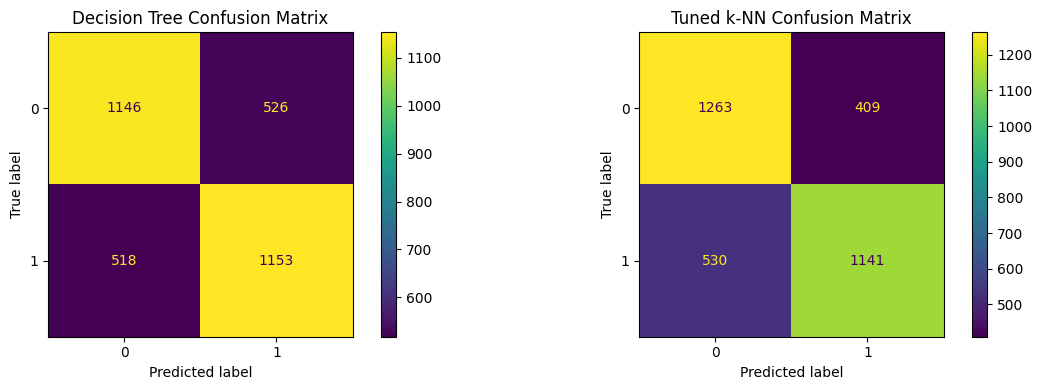

In [7]:
# pick two models to show (Decision Tree + tuned k-NN)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(y_test, dt_pred, ax=axes[0], values_format="d")
axes[0].set_title("Decision Tree Confusion Matrix")

ConfusionMatrixDisplay.from_predictions(y_test, best_knn_pred, ax=axes[1], values_format="d")
axes[1].set_title("Tuned k-NN Confusion Matrix")

plt.tight_layout()
plt.show()

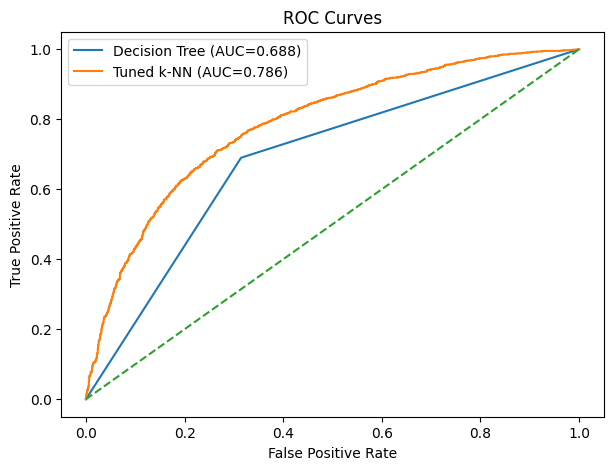

In [8]:
def plot_roc(model, X_te, y_te, label):
    # need probabilities for ROC
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)[:, 1]
    else:
        # fallback: use decision_function if available
        proba = model.decision_function(X_te)
        proba = (proba - proba.min()) / (proba.max() - proba.min() + 1e-9)

    fpr, tpr, _ = roc_curve(y_te, proba)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# probs
fpr_dt, tpr_dt, auc_dt = plot_roc(dt, X_test, y_test, "Decision Tree")
fpr_knn, tpr_knn, auc_knn = plot_roc(best_knn, X_test, y_test, "Tuned k-NN")

plt.figure(figsize=(7,5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc_dt:.3f})")
plt.plot(fpr_knn, tpr_knn, label=f"Tuned k-NN (AUC={auc_knn:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [ ]:
## Step 6: Clustering Using K-Means

# Clustering is used to discover hidden patterns in the dataset without using target labels.

# Steps:
# 1. Standardize features
# 2. Determine optimal number of clusters usinng K selection
# 3. Fit K-Means model
# 4. Assign cluster labels
# 5. Visualize clusters using PCA (2D projection)


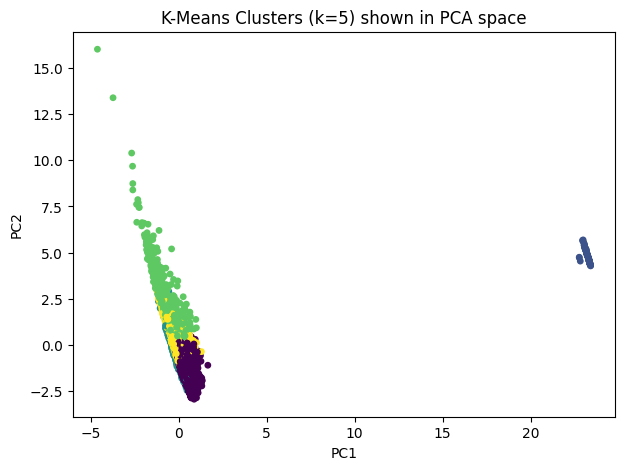

cluster
0          6846
1            88
2           182
3          3841
4          5755
Name: count, dtype: int64

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Use numeric-only features for clustering (no target)
Xc = df.drop(columns=[target]).select_dtypes(include=["int64","float64"]).copy()
Xc = Xc.replace([np.inf, -np.inf], np.nan)
Xc = Xc.fillna(Xc.median(numeric_only=True))

# scale
scaler = StandardScaler()
Xc_scaled = scaler.fit_transform(Xc)

# choose k (start with 3–5; adjust if needed)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(Xc_scaled)

# PCA to 2D for plotting
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(Xc_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=clusters, s=15)
plt.title(f"K-Means Clusters (k={k}) shown in PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

df_clusters = df.copy()
df_clusters["cluster"] = clusters
df_clusters[["cluster"]].value_counts().sort_index()


In [10]:
# Cluster summaries (mean of numeric columns)
cluster_profile = df_clusters.groupby("cluster").mean(numeric_only=True)
cluster_profile


,rev_util,age,late_30_59,debt_ratio,monthly_inc,open_credit,late_90,real_estate,late_60_89,dependents,dlq_2yrs
cluster,,,,,,,,,,,
0,0.745488,41.113622,0.746118,0.663451,4233.140134,5.647898,0.580987,0.496654,0.318268,1.068047,0.657240
1,1.000000,37.193182,97.931818,0.004984,2510.159091,0.011364,97.931818,0.000000,97.931818,0.659091,0.943182
2,0.265806,56.104084,0.450833,0.634590,7726.579089,11.246890,0.125088,1.568998,0.117695,0.829852,0.352265
3,0.420245,46.911602,0.491713,359.205033,3808.839779,8.546961,0.292818,1.116022,0.187845,1.071823,0.353591


In [ ]:
## Step 8: Association Rule Mining (Apriori)

# Association rule mining is used to uncover relationships among features by identifying frequent itemsets and generating rules.

# Since Apriori requires transaction-style (one-hot encoded) data, the dataset is prepared as follows:

# 1. Convert numeric features into categorical bins (e.g., Low / Medium / High)  
# 2. Transform the binned features into one-hot encoded "items"
# 3. Apply the Apriori algorithm to generate frequent itemsets using a minimum support threshold
# 4. Generate association rules using:
#    - Minimum confidence
#    - Lift
# 5. Filter and interpret the strongest rules to extract meaningful patterns.


In [11]:
# If you get "ModuleNotFoundError: mlxtend", uncomment:
%pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

# Pick a few meaningful numeric columns that exist in your df
candidate_cols = ["age", "monthly_inc", "debt_ratio", "rev_util", "open_credit", "dependents"]
candidate_cols = [c for c in candidate_cols if c in df.columns]

if len(candidate_cols) < 3:
    raise ValueError("Not enough expected columns found for rule mining. Update candidate_cols to match your dataset.")

tmp = df[candidate_cols].copy()

# bin into categories (Low/Med/High)
binned = pd.DataFrame()
for c in candidate_cols:
    binned[c] = pd.qcut(tmp[c].rank(method="first"), q=3, labels=[f"{c}_LOW", f"{c}_MED", f"{c}_HIGH"])

# one-hot encode transactions
transactions = pd.get_dummies(binned)

# frequent itemsets
freq = apriori(transactions, min_support=0.10, use_colnames=True)

# rules
rules = association_rules(freq, metric="confidence", min_threshold=0.60)
rules = rules.sort_values(["lift", "confidence"], ascending=False)

rules.head(10)


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 18.0 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"frozenset({rev_util_rev_util_HIGH, debt_ratio_...",frozenset({open_credit_open_credit_LOW}),0.124581,0.333353,0.100826,0.809318,2.427809,1.0,0.059296,3.496117,0.671799,0.282339,0.713968,0.555889
